In [3]:
import pandas as pd 
coffee = pd.read_csv('/Users/mac/Desktop/Coffee Project/Coffe_sales.csv')
coffee.head()

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
0,10,card,38.7,Latte,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000
1,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:19:22.539000
2,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:20:18.089000
3,13,card,28.9,Americano,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000
4,13,card,38.7,Latte,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000


#### PLAN

As found in the previous analysis files, the main determiner of the money spent on coffee is the type of coffee. It's far from ideally accurate, but my goal is to evaluate how good or bad it actually is.
I will get dummies for coffee_name, and then create a Linear Regression.

In [12]:
coffee = pd.read_csv("Coffe_sales.csv")

coffee['Date'] = pd.to_datetime(coffee['Date'])

coffee['Day'] = coffee['Date'].dt.day
coffee['Month'] = coffee['Date'].dt.month

coffee_encoded = pd.get_dummies(coffee, columns=['coffee_name'], drop_first=True)

In [21]:
coffee_encoded.head()

,hour_of_day,cash_type,money,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time,Day,Month,coffee_name_Americano with Milk,coffee_name_Cappuccino,coffee_name_Cocoa,coffee_name_Cortado,coffee_name_Espresso,coffee_name_Hot Chocolate,coffee_name_Latte
0,10,card,38.7,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000,1,3,False,False,False,False,False,False,True
1,12,card,38.7,Afternoon,Fri,Mar,5,3,2024-03-01,12:19:22.539000,1,3,False,False,False,False,False,True,False
2,12,card,38.7,Afternoon,Fri,Mar,5,3,2024-03-01,12:20:18.089000,1,3,False,False,False,False,False,True,False
3,13,card,28.9,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000,1,3,False,False,False,False,False,False,False
4,13,card,38.7,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000,1,3,False,False,False,False,False,False,True


In [22]:
X = coffee_encoded.drop(columns=['Date', 'money', 'cash_type', 'Time_of_Day', 'Weekday', 'Month_name', 'Time'])  # remove non-predictive columns
y = coffee_encoded['money']

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

print("R²:", r2_score(y_test, preds))
print("RMSE:", root_mean_squared_error(y_test, preds))

R²: 0.8700882669455114
RMSE: 1.7239347220842336


This model works. Not ideal, but the R² is quite high, and the RMSE at 1.72 with money of around 35 on average is also great. Now, time to analyze it further. What actually drives the revenue and affects the results?

In [26]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coef_df.head(10))  # top positive influencers
print(coef_df.tail(10))  # top negative influencers

                            Feature  Coefficient
10        coffee_name_Hot Chocolate    10.313212
6            coffee_name_Cappuccino    10.083623
7                 coffee_name_Cocoa     9.854906
11                coffee_name_Latte     9.832750
5   coffee_name_Americano with Milk     4.887400
8               coffee_name_Cortado     0.085769
0                       hour_of_day     0.026102
1                       Weekdaysort     0.021979
3                               Day    -0.004742
2                         Monthsort    -0.087122
                            Feature  Coefficient
7                 coffee_name_Cocoa     9.854906
11                coffee_name_Latte     9.832750
5   coffee_name_Americano with Milk     4.887400
8               coffee_name_Cortado     0.085769
0                       hour_of_day     0.026102
1                       Weekdaysort     0.021979
3                               Day    -0.004742
2                         Monthsort    -0.087122
4                   

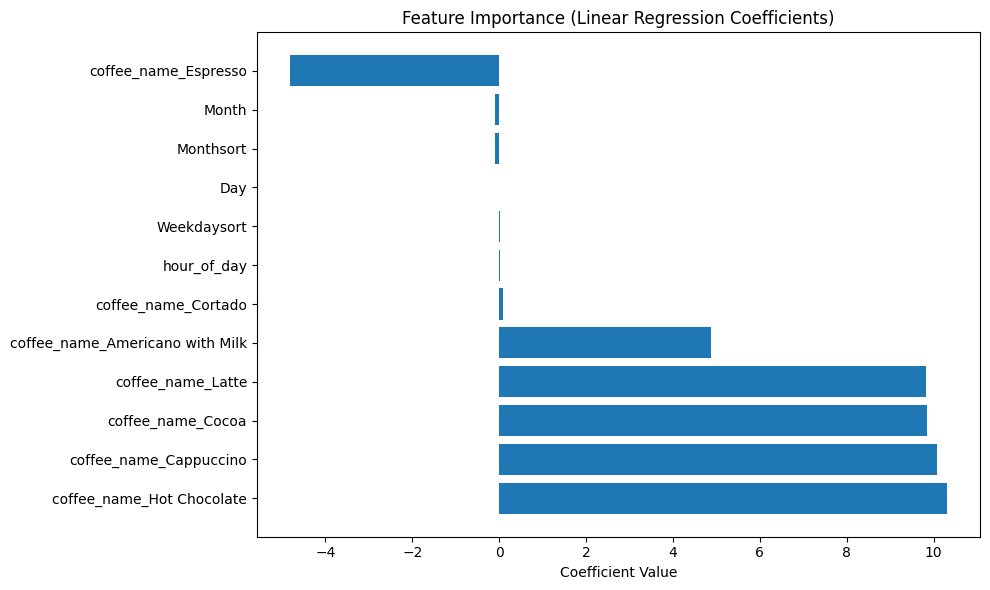

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

**Takeaway**

Revenue varies strongly by product type. Each coffee type has a distinct average revenue impact.

Temporal features (Day, Month, Hour) have almost no weight, so the dataset likely doesn’t contain strong time seasonality, or it’s overshadowed by product pricing differences. Given the drastic difference, and common sense, I'd say it is the case that in terms of coffee, seasonality does not affect the sales in any way. Especially given the fact that ther are no iced coffees in the initial file.

Linear regression fits well because this relationship (different fixed prices per coffee type) is linear by nature.

#### Additional work

**Checking for overfitting**

In [28]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Average CV R²:", scores.mean())

Average CV R²: 0.7783000777729638


Average CV R² is not significantly less, so the model is likely not overfitting.

**Trying a Nonlinear model**

In [29]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
preds_rf = rf.predict(X_test)

print("R²:", r2_score(y_test, preds_rf))
print("RMSE:", root_mean_squared_error(y_test, preds_rf))

R²: 0.988503871806623
RMSE: 0.5128288247495865


The nonlinear model (Random Forest Regressor) achieved **R² ≈ 0.99 and RMSE ≈ 0.51**, significantly outperforming the linear model (R² = 0.87, RMSE ≈ 1.72). This indicates that the relationship between coffee type, time features, and sales is nonlinear and interaction-based. Random Forest captures these dependencies effectively, leading to near-perfect prediction accuracy on held-out data.

*Overfitting?*

In [30]:
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("Cross-validation R²:", cv_scores)
print("Mean:", cv_scores.mean(), "Std:", cv_scores.std())

Cross-validation R²: [0.81419226 0.72478313 0.74161085 0.99912936 0.82551351]
Mean: 0.8210458223661291 Std: 0.09732121986961685


Unfortunately, Random Forest is a bit too flexible and overfits in some folds.

*Potential Solution 1:* I'll try to limit depth

In [31]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42
)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [32]:
preds_rf = rf.predict(X_test)

print("R²:", r2_score(y_test, preds_rf))
print("RMSE:", root_mean_squared_error(y_test, preds_rf))

R²: 0.8500946970388248
RMSE: 1.8518471051543357


In [33]:
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("Cross-validation R²:", cv_scores)
print("Mean:", cv_scores.mean(), "Std:", cv_scores.std())

Cross-validation R²: [0.6448445  0.68898312 0.81605181 0.97892897 0.81614018]
Mean: 0.7889897153299847 Std: 0.1168978940361355


This did not change a lot, unfortunately

*Potential Solution 2:* Fewer Features

In [35]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    max_features='sqrt',
    random_state=42
)

rf.fit(X_train, y_train)

preds_rf = rf.predict(X_test)

print("R²:", r2_score(y_test, preds_rf))
print("RMSE:", root_mean_squared_error(y_test, preds_rf))
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("Cross-validation R²:", cv_scores)
print("Mean:", cv_scores.mean(), "Std:", cv_scores.std())

R²: 0.8769036436502696
RMSE: 1.6781053723280916
Cross-validation R²: [0.64995927 0.63123778 0.71949318 0.89731262 0.66274346]
Mean: 0.712149262278959 Std: 0.09715410139002015


Same result.

*Potential solution 3:* Fewer trees

In [41]:
rf = RandomForestRegressor(
    n_estimators=150,
    max_depth=8,
    random_state=42
)

rf.fit(X_train, y_train)

preds_rf = rf.predict(X_test)

print("R²:", r2_score(y_test, preds_rf))
print("RMSE:", root_mean_squared_error(y_test, preds_rf))
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("Cross-validation R²:", cv_scores)
print("Mean:", cv_scores.mean(), "Std:", cv_scores.std())

R²: 0.9611006336067915
RMSE: 0.9433392233794706
Cross-validation R²: [0.80282814 0.73127692 0.77629972 0.99251264 0.85105588]
Mean: 0.8307946572859828 Std: 0.0896870435342337


There is progress. However, one of the cross-validation is abnormally high at 0.9925.

Maybe it will be better to *Increase Minimum Samples per Split / Leaf*

In [48]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=7,
    min_samples_split=15,
    min_samples_leaf=10,
    random_state=42
)

rf.fit(X_train, y_train)

preds_rf = rf.predict(X_test)

print("R²:", r2_score(y_test, preds_rf))
print("RMSE:", root_mean_squared_error(y_test, preds_rf))
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("Cross-validation R²:", cv_scores)
print("Mean:", cv_scores.mean(), "Std:", cv_scores.std())

R²: 0.9284818380085947
RMSE: 1.279100889824952
Cross-validation R²: [0.72773035 0.70945098 0.81645665 0.97462089 0.92396289]
Mean: 0.8304443525315695 Std: 0.10480249141623563


Here, the outlying cv_score decreased, however the mean is unchanged, while standart deviation increased, which is not a good sign. Overall, it is a regress.

#### Summary: 

The Linear Model showed worse performance, compared to Nonlinear. However, Linear model was likely *not* overfitting, while RandomForestRegressor was.

For this exact coffee dataset the best way to fix overfitting RandomForestRegressor was *to decrease the amount of trees*.

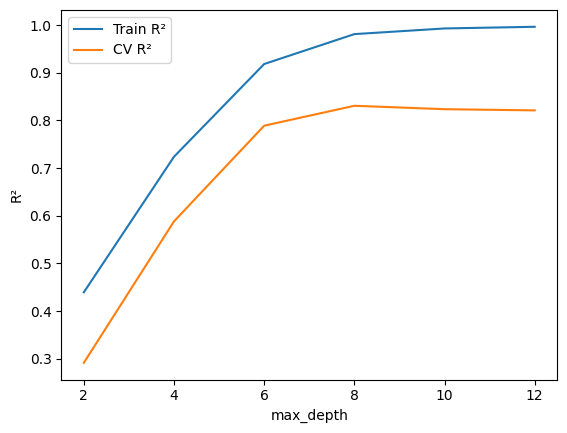

In [49]:
from sklearn.model_selection import validation_curve
import numpy as np

param_range = [2, 4, 6, 8, 10, 12, None]
train_scores, test_scores = validation_curve(
    RandomForestRegressor(n_estimators=200, random_state=42),
    X, y,
    param_name="max_depth",
    param_range=param_range,
    cv=5,
    scoring="r2"
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_mean, label="Train R²")
plt.plot(param_range, test_mean, label="CV R²")
plt.xlabel("max_depth")
plt.ylabel("R²")
plt.legend()
plt.show()


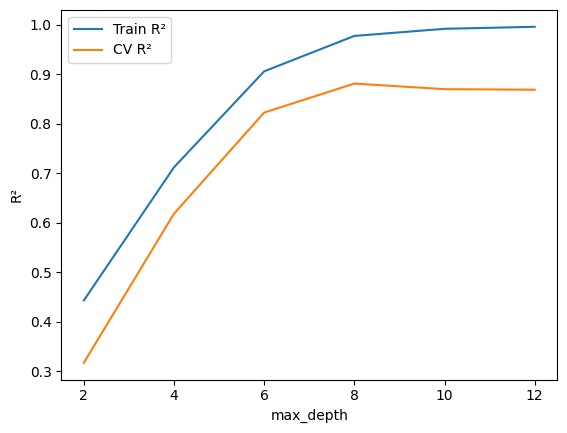

In [51]:
param_range = [2, 4, 6, 8, 10, 12, None]
train_scores, test_scores = validation_curve(
    RandomForestRegressor(n_estimators=150, max_depth = 8, random_state=42),
    X, y,
    param_name="max_depth",
    param_range=param_range,
    cv=10,
    scoring="r2"
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_mean, label="Train R²")
plt.plot(param_range, test_mean, label="CV R²")
plt.xlabel("max_depth")
plt.ylabel("R²")
plt.legend()
plt.show()

From these visualizations we can see, that if we take double the CVs, and adapt RandomForestRegressor, we achieve progress, that is actually visible on the graph.